In [1]:
import warnings
warnings.filterwarnings('default')

In [2]:
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

import lvm_read
import pyFRF
import pyidi
import pyEMA

import tqdm
import cv2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter
import tqdm


%matplotlib inline

Validation errors in config file(s).
The following fields have been reset to the default value:

schema_version
  value is not a valid tuple (type=type_error.tuple)

/home/maheswaran/miniconda3/envs/myenv/lib/python3.7/site-packages/pyEMA/__init__.py:12: UserWarning: This is the last version of pyEMA and will not longer be maintained since it is moving to the SDyPy package. To use the latest code from SDyPy: `pip install sdypy` and `from sdypy import EMA`.
  warnings.warn('This is the last version of pyEMA and will not longer be maintained since it is moving to the SDyPy package. To use the latest code from SDyPy: `pip install sdypy` and `from sdypy import EMA`.')


In [3]:
def plot_images(image, zoom=False):
    if zoom:
        plt.figure(figsize=(20, 20))
    plt.imshow(image)
    
def plot_pyramid(pyramids):
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
    yiq = ["y", "i", "q"]
    for i in range(4):
        for j in range(3):
            plt.title(f"Level:{i}, Color scheme: {yiq[j]}")
            ax[i, j].imshow(pyramids[i][:,:,j])
    
    plt.show()

def plot_fft_image(image):
    plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft(image)))))

def plot_fft_pyramid(pyramids):
    fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
    
    for i in range(4):
        for j in range(3):
            ax[i, j].imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft(pyramids[:,:,j])))))
    plt.show()
    
def play_video(video_path, isColor = False):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        if isColor:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAYR)
        cv2.imshow('Frame', frame)
        
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

In [4]:
video_path = "data/camera.cih"
output_path = "results/motion_magnified.mp4"

gaussian_kernel = (
    np.array(
        [
            [1,  4,  6,  4, 1],
            [4, 16, 24, 16, 4],
            [6, 24, 36, 24, 6],
            [4, 16, 24, 16, 4],
            [1,  4,  6,  4, 1]
        ]
    )
    / 256
)

yiq_from_rgb = (
    np.array(
            [
                [0.29900000,  0.58700000,  0.11400000],
                [0.59590059, -0.27455667, -0.32134392],
                [0.21153661, -0.52273617,  0.31119955]
            ]
        )
    ).astype(np.float32)

rgb_from_yiq = np.linalg.inv(yiq_from_rgb)

level = 4
alpha  = 100
lc = 40
at = 0.1
mode = 'laplacian'
lo = 1
ho = 10

# 100 40 100 120 600
# 50 40 72 92 600

freq_range = [lo, ho]

In [5]:
play_video(video_path)

[ERROR:0@0.842] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.7.0) /io/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): data/camera.cih in function 'icvExtractPattern'




In [6]:
# Load Video and get fps
def loadVideo(video_path):
    image_sequence = []
    
    video = cv2.VideoCapture(video_path)
    fps = video.get(cv2.CAP_PROP_FPS)
    
    height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    
    while video.isOpened():
        ret, frame = video.read()

        if ret is False:
            break
            
        image_sequence.append(frame[:, :, ::-1])

    video.release()

    return np.asarray(image_sequence), fps, height, width

def rgb2yiq(rgb_image):
    image = rgb_image.astype(np.float32)
    return image @ yiq_from_rgb.T


def yiq2rgb(yiq_image):
    image = yiq_image.astype(np.float32)
    return image @ rgb_from_yiq.T


In [7]:
def pyrDown(image, kernel):
    return cv2.filter2D(image, -1, kernel)[::2, ::2]

def pyrUp(image, kernel, dst_shape=None):
    dst_height = image.shape[0] + 1
    dst_width = image.shape[1] + 1

    if dst_shape is not None:
        dst_height -= (dst_shape[0] % image.shape[0] != 0)
        dst_width -= (dst_shape[1] % image.shape[1] != 0)

    height_indexes = np.arange(1, dst_height)
    width_indexes = np.arange(1, dst_width)

    upsampled_image = np.insert(image, height_indexes, 0, axis=0)
    upsampled_image = np.insert(upsampled_image, width_indexes, 0, axis=1)

    return cv2.filter2D(upsampled_image, -1, 4 * kernel)

In [8]:
def generateLaplacianPyramid(image, kernel, level):
    laplacian_pyramid = []
    prev_image = image.copy()

    for _ in range(level):
        downsampled_image = pyrDown(image=prev_image, kernel=kernel)
        upsampled_image = pyrUp(image=downsampled_image,
                                kernel=kernel,
                                dst_shape=prev_image.shape[:2])
        laplacian_pyramid.append(prev_image - upsampled_image)
        prev_image = downsampled_image

    return laplacian_pyramid

def getLaplacianPyramids(images, kernel, level):
    laplacian_pyramids = []

    for image in tqdm.tqdm(images,
                           ascii=True,
                           desc="Laplacian Pyramids Generation"):

        laplacian_pyramid = generateLaplacianPyramid(
                                    image = rgb2yiq(image),
#                                     image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY),
                                    kernel=kernel,
                                    level=level
                        )
        laplacian_pyramids.append(laplacian_pyramid)

    return np.asarray(laplacian_pyramids, dtype='object')

In [9]:
def filterLaplacianPyramids(pyramids,
                            level,
                            fps,
                            freq_range,
                            alpha,
                            lambda_cutoff,
                            attenuation):

    filtered_pyramids = np.zeros_like(pyramids)
    filt_pyr_original = np.zeros_like(pyramids)
    delta = lambda_cutoff / (8 * (1 + alpha))
    b_low, a_low = butter(1, freq_range[0], btype='low', output='ba', fs=fps)
    b_high, a_high = butter(1, freq_range[1], btype='low', output='ba', fs=fps)

    lowpass = pyramids[0]
    highpass = pyramids[0]
    filtered_pyramids[0] = pyramids[0]
    for i in tqdm.tqdm(range(1, pyramids.shape[0]),
                       ascii=True,
                       desc="Laplacian Pyramids Filtering"):

        lowpass = (-a_low[1] * lowpass
                   + b_low[0] * pyramids[i]
                   + b_low[1] * pyramids[i - 1]) / a_low[0]
        highpass = (-a_high[1] * highpass
                    + b_high[0] * pyramids[i]
                    + b_high[1] * pyramids[i - 1]) / a_high[0]

        filtered_pyramids[i] = highpass - lowpass
        filt_pyr_original[i] = highpass - lowpass
        for lvl in range(1, level - 1):
            (height, width, _) = filtered_pyramids[i, lvl].shape
            lambd = ((height ** 2) + (width ** 2)) ** 0.5
            new_alpha = (lambd / (8 * delta)) - 1

            filtered_pyramids[i, lvl] *= min(alpha, new_alpha)
            filtered_pyramids[i, lvl][:, :, 1:] *= attenuation

    return filtered_pyramids, filt_pyr_original

In [10]:
# Collapse the laplacian image
def reconstructLaplacianImage(image, pyramid, kernel):
    reconstructed_image = rgb2yiq(image)

    for level in range(1, pyramid.shape[0] - 1):
        tmp = pyramid[level]
        for curr_level in range(level):
            tmp = pyrUp(tmp, kernel, pyramid[level - curr_level - 1].shape[:2])
        reconstructed_image += tmp.astype(np.float32)    
    reconstructed_image = yiq2rgb(reconstructed_image)
    reconstructed_image = np.clip(reconstructed_image, 0, 255)

    return reconstructed_image.astype(np.uint8)

def getLaplacianOutputVideo(original_images, filtered_images, kernel):
    video = np.zeros_like(original_images)
    # Write filtered images
    freqs = []
    for i in tqdm.tqdm(range(original_images.shape[0]),
                       ascii=True,
                       desc="Video Reconstruction"):

        video[i] = reconstructLaplacianImage(
                    image=original_images[i],
                    pyramid=filtered_images[i],
                    kernel=kernel
                )
    return video

In [11]:
# save video
def saveVideo(video, saving_path, fps):
    (height, width) = video[0].shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = cv2.VideoWriter(saving_path, fourcc, fps, (width, height))

    for i in tqdm.tqdm(range(len(video)), ascii=True, desc="Saving Video"):
        writer.write(video[i][:, :, ::-1])

    writer.release()

In [12]:
# images, fps, height, width = loadVideo(video_path)
video_py = pyidi.pyIDI(cih_file='data/camera.cih')
video_np = np.array(video_py.mraw)
fps = video_py.fps

images = np.array([cv2.cvtColor(i, cv2.COLOR_GRAY2BGR) for i in video_np])
print(f"fps : {fps}, image_shape : {images.shape}")

laplacian_pyramids = getLaplacianPyramids(images, 
                                          kernel=gaussian_kernel, 
                                          level=level)

filtered_pyramids, filt_pyr_original = filterLaplacianPyramids(
                                            pyramids=laplacian_pyramids,
                                            fps=fps,
                                            freq_range=freq_range,
                                            alpha=alpha,
                                            lambda_cutoff=lc,
                                            attenuation=at,
                                            level=level)
magnified_images = getLaplacianOutputVideo(original_images=images,
                                          filtered_images=filtered_pyramids,
                                          kernel=gaussian_kernel)

/home/maheswaran/miniconda3/envs/myenv/lib/python3.7/site-packages/pyMRAW.py:91: UserWarning: Not 12bit (8 bits)! clipped values?
  warnings.warn('Not 12bit ({:g} bits)! clipped values?'.format(bits))
/home/maheswaran/miniconda3/envs/myenv/lib/python3.7/site-packages/pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 3750, Original total frame: 7500)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


fps : 15000, image_shape : (3750, 40, 640, 3)


Video Reconstruction: 100%|################| 3750/3750 [00:04<00:00, 752.30it/s]


In [13]:
grad0, grad1 = np.gradient(video_np[0].astype(float)) # gradient computation
reference_image = np.average(video_np[:10], axis=0)
grad0, grad1 = np.gradient(reference_image)

border = 20
border_h = 12
n = 2
N = 16
w = np.arange(border, reference_image.shape[1]-border, np.abs(border - reference_image.shape[1]-border)//N)
h = np.argsort(np.abs(grad0[border_h:-border_h, w]), axis=0)[-n:, :].T + border_h
inds = np.column_stack((h.flatten(), w.repeat(n)))

video_py.set_points(points=inds)
video_py.set_method(method='sof',
                mean_n_neighbours=n)
displacements_original = video_py.get_displacements() * 8e-5 

points_lk = np.column_stack([np.ones_like(w)*video_py.info['Image Height']//2, w])
video_py.set_points(points_lk)
video_py.set_method('lk', roi_size=(21, 23), max_nfev=10, int_order=3)
displacements_algo = video_py.get_displacements(processes=1, autosave=False) * 8e-5 

displacements_algo += np.random.normal(0, 1e-6, displacements_algo.shape)

100%|█████████████████████████████████████████████████████████| 3750/3750 [00:02<00:00, 1748.75it/s]


Averaging...
Finished!
--- Starting new analysis ---
 
Interpolating the reference image...
...done in 0.02 s


/home/maheswaran/miniconda3/envs/myenv/lib/python3.7/site-packages/pyidi/methods/_simplified_optical_flow.py:138: UserWarning: Displacement larger than 0.5 pixel
  warnings.warn('Displacement larger than 0.5 pixel')
/home/maheswaran/miniconda3/envs/myenv/lib/python3.7/site-packages/pyidi/methods/_lucas_kanade.py:464: ResourceWarning: unclosed file <_io.BufferedWriter name='data/temp_file/settings.pkl'>
  pickle.dump(settings, open(self.settings_filename, 'wb'))
/home/maheswaran/miniconda3/envs/myenv/lib/python3.7/site-packages/pyidi/methods/_lucas_kanade.py:466: ResourceWarning: unclosed file <_io.BufferedWriter name='data/temp_file/points.pkl'>
  pickle.dump(self.video.points, open(self.points_filename, 'wb'))
/home/maheswaran/miniconda3/envs/myenv/lib/python3.7/site-packages/pyidi/methods/_lucas_kanade.py:485: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is saf

VBox()

Time to complete: 51.6 s


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fd5501eb980>


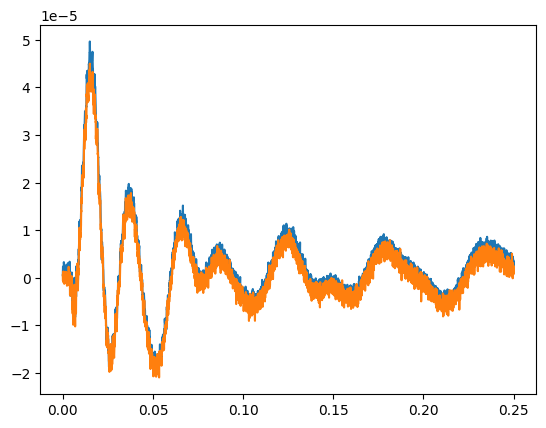

In [19]:
# Plot displacements with respect to time

point = 0
t = np.linspace(0, video_np.shape[0]/fps, video_np.shape[0])
plt.plot(t, displacements_original[point, :, 0], label='original displacements')
plt.plot(t, displacements_algo[point, :, 0], label='motion magnified displacements')
plt.show()

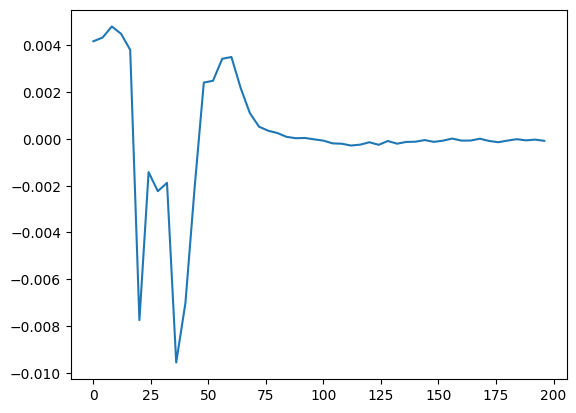

In [25]:
# Get fft of displacements
freqs = np.fft.fftfreq(video_np.shape[0], 1/fps)
fft = np.fft.fft(displacements_algo[point, :, 0])
plt.plot(freqs[:50], fft[:50])